## 8.6 약한참조

- 객체가 메모리에 유지되는지 여부는 참조의 존재 여부
- 객체 참조 카운트가 0이 되면 가비지 컬렉터는 해당 객체를 제거.
- 불필요하게 객체를 유지시키지 않으면서 객체를 참조할 수 있으면 도움디 된다. 대표적으로 `캐시`.


- 약한 참조는 참조 카운트를 증가시키지 않고 객체를 참조. > 가비지 컬렉트되는 것을 방지하지 않는다.
- 참조의 대상인 객체를 `referent`라고 한다.


- 약한 참조는 캐시 애플리케이션에서 유용. 캐시가 참조하고 있다고 해서 캐시된 객체가 계속 남아 있기 원치 않기 때문에.


- ex 8-17은 wrakref.ref 객체를 호출해서 참조 대상에 접근하는 방법을 보여준다.
- 객체가 살아 있으면 약한 참조 호출은 참조된 객체를 반환, 아니면 None 반환

In [6]:
# ex 8-17 약한 참조는 콜러블이다. 객체가 살아있으면 참조된 객체를 반환하고, 그렇지 않으면 None을 반환.
import weakref

a_set = {0, 1}
wref = weakref.ref(a_set)
wref

<weakref at 0x0000024F33D3D818; to 'set' at 0x0000024F33CF4D68>

In [7]:
wref()

{0, 1}

In [8]:
a_set = {2, 3, 4}
wref()

{0, 1}

In [9]:
wref() is None

False

In [10]:
wref() is None

False

> 여기선 안된다.


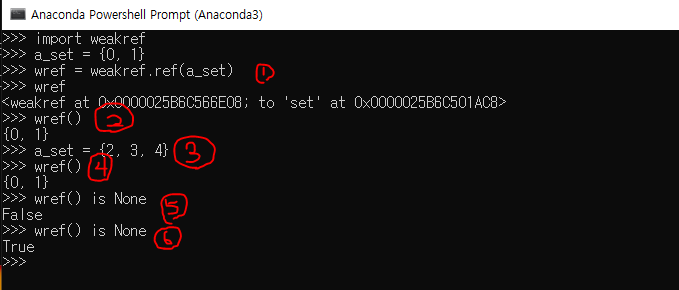


> 이걸로는 된다.

1. 약한 참조 객체 wref 생성
2. wref()를 호출하면 참조된 객체 {0, 1}을 반환. 콘솔 세션에서 실행하고 있으므로 결과로 나온 {0, 1}이 `_` 변수에 바인딩 된다.
3. a_set이 더 이상 {0, 1} 집합을 참조하지 않으므로 참조 카운트가 줄어든다. 그렇지만 `_`변수가 여천히 {0, 1}을 참조한다.
4. wref()를 호출하면 여천히 {0, 1}이 반환된다.
5. 표현식을 평가할 때 {0, 1}이 살아 있으므로 wref()는 `None`이 아니다. 그렇지만 `_`는 결과값인 False에 바인딩된다. 이제 `_`변수는 더 이상 {0, 1}을 참조하지 않는다.
6. 이제 {0, 1} 객체가 제거되읐으므로 wref()를 호출하면 `None` 반환된다.

#### TIP

- 파이썬 콘솔은 `None`이 아닌 표현식의 결과에 `_`변수를 자동으로 할당한다.
- 예제가 실제 상황을 잘 보여준다.
- 메모리를 섬세하게 제어하고자 할 때, 객체에 새로운 참조를 생성하는 암묵적인 할당 때문에 당황하는 경우가 종종있다.

- weakref 모듈 문서에서는 weakref.ref 클래스는 고급 사용자를 위한 저수준 인터페이스며, 일반 프로그래머는 weakref 컬렉션과 finlize()를 사용하는 것이 좋다고 설명한다.
- 즉, weakref.ref 객체를 직접 만들기보다는 WeakKeyDictionary, weakValueDictionary, WeakSet, 그리고 내부적으로 약한 참조를 이용하는 finalize()를 사용하는 것이 좋다.
- ex 8-17에서는 weakref.ref 객체 하나가 작동하는 방식을 보면서 약한 참조 개념을 익히기 위해 weakref.ref 객체를 직접 만들었지만, 실제로 대부분의 파이썬 프로그램은 weakref 컬렉션을 사용한다.
- weakref 컬렉션에 대해 간단히 살펴보자

### 8.6.1 WeakValueDictionary 촌극(skit)

- WeakValueDictionary 클래스는 객체에 대한 약한 참조를 값으로 가지는 가변 매핑을 구현한다.
- 참조된 객체가 프로그램 다른곳에서 가비지 컬렉트되면 해당 키도 WeakValueDictionary에서 자동으로 제거된다.
- 일반적으로 캐시를 구현하기 위해 사용된다.


- 사용 예는 몬티 파이튼의 고전적인 `치즈 가게` 촌극에서 양감을 받았다.
- 치즈 가게 촌극에서는 체다, 모차렐라 등 40여 종의 치즈를 고객이 주문하지만, 그중 어느것도 재고가 없다.

In [19]:
# ex 8-18 kind 속성과 표준 표현 메서드를 가지고 있는 Cheese 클래스

class Cheese:
    
    def __init__(self, kind):
        self.kind = kind
        
    def __repr__(self):
        return "Cheese(%r)" % self.kind

- ex 8-19 에서는 catalog에 들어있는 각종 치즈가 WeakValueDictionary로 구현되어 있는 `stock 배열`에 로딩된다.
- 그런데 catalog를 제거하자마자 `stock`에 있는 치즈가 하나만 빼고 모두 사라진다.
- 파르마 치즈가 다른 치즈보다 오래 남아 있는 이유는 무엇일까?
> 1년간 숙성해야 하므로 더 오래간다

In [22]:
import weakref
stock = weakref.WeakValueDictionary()   # 1
catalog = [Cheese("Red Leicester"), Cheese("Tilsit"), Cheese("Brie"), Cheese("Parmesan")]

for cheese in catalog:
    stock[cheese.kind] = cheese    # 2

sorted(stock.keys())    # 3

['Brie', 'Parmesan', 'Red Leicester', 'Tilsit']

In [23]:
del catalog
sorted(stock.keys())    # 4

['Parmesan']

In [24]:
del cheese
sorted(stock.keys())

[]

1. stock은 WeakValueDictionary 객체다
2. 치즈명을 catalog에 있는 `Cheese`객체에 대한 약한 참조로 매핑한다.
3. 모든 치즈명이 들어 있다.
4. catalog를 제거한 후, 예상한 대로 WeakValueDictionary 객체인 stock에서 대부분의 치즈가 사라졌다. 그런데 하나가 남아 있는 이유는?

#### tip

- 임시 변수가 객체를 참조함으로써 예상보다 객체의 수명이 늘어날 수 있다.
- 지역 변수는 함수가 반환되면서 사리지므로 일반적으로 문제가 되지 않는다.
- 그러나 ex 8-19 의 경우 for 루프 변수인 cheese는 전역 변수이르모, 명시적으로 제거하기 전에는 사라지지 않는다.


#### WeakKeyDictionary

- WeakKeyDictionary 클래스는 키가 약한 참조.
- weakref.WeakKeyDictionary 문서에서
    - 애플리케이션의 다른 부분에서 소유하고 있는 객체에 속성을 추가하지 않고 추가적인 데이터를 연결할 수 있다. 이 클래스는 속성 접근을 오버라이드하는 객체(디스크립터)에 특히 유용한다.
    
#### WeakSet

- weakref.WeakSet 문서에서
    - 요소를 약한 참조로 가리키는 집합 클래스
    - 어떤 요소에 대한 참조가 더 이상 존재하지 않으면 해당 요소가 제거된다.

- 자신의 객체를 모두 알고 있는 클래스를 만들어야 한다면, 각 객체에 대한 참조를 모두 WeakSet 형의 클래스 속성에 저장하는 것이 좋다.
- 그렇게 하지 않고 일반 집합을 사용하면 이 클래스로 생성한 모든 객체는 가비지 컬렉트되지 않을 것이다.
- 클래스 자체가 객체에 대한 강한 참조를 하므로, 명시적으로 제거하지 않는 한 파이썬 프로세스가 종료될 때까지 객체가 제거되지 않기 때문이다.

### 8.6.2 약한 참조의 한계

- 모든 객체가 약한 참조의 대상은 아니다.
- list와 dict 객체는참조 대상이 될 수 없지만, 이 클래스들의 서브클래스는 이 문제를 다음 코드처럼 쉽게 해결할 수 있다.

In [25]:
class MyList(list):
    """약한 참조의 대상이 될 수 있는 list 서브클래스"""
    
a_list = MyList(range(10))

# a_list는 약한 참조의 대상이 될 수 있다.
wref_to_a_list = weakref.ref(a_list)

In [26]:
b_list = list(range(10))
wref_to_b_list = weakref.ref(b_list)

TypeError: cannot create weak reference to 'list' object

In [28]:
b_dict = {1:1}
wref_to_b_dict = weakref.ref(b_dict)

TypeError: cannot create weak reference to 'dict' object

In [29]:
b_set = {1}
wref_to_b_set = weakref.ref(b_set)

- set 객체는 가능.
- 사용자 정의형도 참도 대상이 될 수 있다.
- 그래서 ex 8-19에서 바보 같은 Cheese 클래스가 필요했던 것이다.
- 그러나 int 및 tuple 객체는 클래스를 상속해도 약한 참조의 대상이 될 수 없다.


- 이러한 제약사항 대부분은 CPython 구현 방식에 따른 것이므로, 다른 파이썬 구현에서는 적용되지 않을 수도 있다.
- 내부 구현 최적화에 의해 발생하는 문제이며, 일주에 대해 다음 절에서 설명한다.

### 8.7 파이썬의 특이한 불변형 처리법

#### note

- 이 절은 읽지 않고 넘어가도 좋다.
- 파이썬 구현 내용에 대해 설명하며 파이썬 `사용자`에게 정말 중요한 것은 아니다.
- CPython 핵심 개발자가 수행항 편법과 최적화 관련.



- 튜플 t에 대해 `t[:]`가 사본을 생성하지 않고 그 객체에 대한 참조를 반환한다. `필자는 당황했다.`
- `tuple(t)`로 작성하더라도 튜플 t에 대한 참조가 반환된다.
- 이 부분은 문서화 되어있다.
      If the argument is a tuple, the return value is the same object.
      
- 예제로 알아보자

In [30]:
# ex 8-20 다른 튜플로 생성한 튜플은 사실 동일한 튜플이다.

t1 = (1, 2, 3)
t2 = tuple(t1)
t2 is t1

True

In [31]:
t3 = t1[:]
t3 is t1

True

- t1, t2, t3가 동일한 객체에 바인딩되어 있다.


- str, bytes, frozenset 객체에서도 이와 동일한 동작을 볼 수 있다.
- frozenset이 시퀀스가 아니므로 frozenset 형인 fs에 대해 `fs[:]`는 작동하지 않지만, `fs.copy()`는 동일하게 작동한다.
- 즉 `fs.copy()`는 사본이 아니라 동일 객체에 대한 참조를 반환한다.
- 예제로 알아보자

In [32]:
# ex 8-20

t1 = (1, 2, 3)
t3 = (1, 2, 3)    # 1
t3 is t1    # 2

False

In [33]:
s1 = "ABC"
s2 = "ABC"    # 3
s2 is s1    # 4

True

1. 튜플을 처음부터 새로 만든다.
2. t1과 t3가 동일하게 내용을 갖고 있지만 동일 객체는 아니다.
3. 두번째 str을 처음부터 새로 만든다.
4. s1과 s2가 동일한 str을 참조한다.

- 문자열 리터럴을 공유하는 최적화 기법을 `인터닝 interning` 이라고 한다.
- CPython 에서는 0, -1, 42 등 '인기 있는' 숫자를 불필요하게 중복하지 않도록 작은 정수에도 동일한 기법을 사용한다.
- CPython이 모든 문자열이나 정수를 인터닝하는 것은 아니며, 인터닝 기준은 구현 특징으로서 문서화되어 있지 않다.

#### caution

- 절대로 str이나 int형의 인터닝에 의존하면 안된다.
- 값을 비교할 때는 is가 아니라 ==을 사용해야 한다.
- 인터닝은 파이썬 인터프리터의 내부 구현 특성일 뿐인다.


- frozenset.copy()의 작동 등 이 절에서 설명한 기법은 '선의의 거짓말'로서, 메모리 사용량을 줄이고 인터프리터가 더 빨리 실행되게 한다.
- 이런 특성에 대해 너무 신경 쓸 필요는 없다.
- 불변형에만 적용되므로 아무런 문제도 생기지 않는다.
- 내기할때 써먹어라

In [34]:
s1 = "ABC"
s2 = "ABC"
s1 is s2

True

In [35]:
s1 += "D"
s2 += "D"
s1 is s2

False

In [36]:
s1, s2

('ABCD', 'ABCD')

### 8.8 요약

- 모든 파이썬 객체는 정체성, 자료형, 값을 가지고 있다. 코드가 실행되는 동안 객체는 값만 바뀔 뿐인다.
> 객체의 __class__ 속성을 변경함으로써 객체의 클래스를 변경할 수 있지만, 하면 안된다.

- 변수 두 개가 동일한 값을 가진 불변 객체(a == b가 참이다)를 가리키는 있다면, 변수가 각각의 사본을 가키고 있는지 아니면 동일 객체에 대한 별명인지는 중요하지 않다.
- 어쨌든 불변객체는 변하지 않기 때문이다.
- 단, 튜플이나 frozenset 등의 불변 컬렉션인 경우는 예외. 불변 컬렉션이 가변 항목에 대한 참조를 담고 있는 경우, 가변 항목의 값이 바뀔 때 컬렉션의 값도 바뀐다. 이런 상황이 흔한 것은 아니다.
- 불변 컬렉션에서 바뀌지 않는 것은 그 안에 들어 있는 객체의 정체성이며, 불변 컬력션이 참조하는 가변 객체가 바뀌는 것을 막지 않는다.


- 변수가 참조를 담고 있다는 사실은 파이썬 프로그래밍에서 실제로 다음과 같은 영향을 미친다.
    - 단순 할당문은 사본을 생성하지 않는다.
    - `+=` 나 `*=` 같은 복합 할당 연산자는 왼쪽 변수가 불변 객체에 바인딩되어 있을 때는 객체를 새로 생성하고, 가변 객체에 바인딩되어 있을 때는 기존 객체를 변경한다.
    - 기존 변수에 새로운 값을 할당하면 기존에 바인딩되어 있던 객체를 변경하지 않는다. 이것을 재바인딩 rebinding 이라고 하며, 변수가 새로운 객체에 바인딩되로고 만든다. 그 변수가 기존 객체를 참조하는 마지막 참조였다면, 기존 객체는 가비지 컬렉트된다.
    - 함수 매개변수는 별명으로 전달되므로, 함수는 인수로 전달받은 가변 객체를 모두 변경할 수 있다. 가변 객체의 변경을 막으려면 함수 안에서 사본을 생성하거나, 리스트 대신 튜플을 전달하는 등 불변 객체를 사용해야 한다.
    - 함수 매개변수의 기본값으로 가변 객체를 사용하는 것은 위험한다. 배개변수를 변경하면 기본값이 변경되어 이 기본값을 사용하는 함수가 나중에 호추뢸 때 영향을 받기 때문인다.
    
    
- CPython에서 객체는 참조수가 0이 되는 순간 제거된다.
- 순환 찬조 그룹을 형성해서 외부에서 참조할 수 없을 때도 제거된다.
- 때로는 객체의 참조수를 증가시키지 않으면서 객체를 참조해야 하는 경우가 있다. 자신의 객체를 모두 추적하려는 클래스의 경우가 이에 해당. 이 때는 약한 참조를 사용한다.
- 약한 참조는 weakref 모듈의 WeakValueDictionary, WeakKeydictionary, WeakSet 컬렉션 및 finalize() 함수의 기반이 되는 메커니즘이다.

### 8.9 읽을거리

객체의 정체성과 값, 메모리 모델 등등 읽어 볼만한 것들 소개.

- 뒷이야기
> 기사는 앨리스를 농락하고 있다.